In [1]:
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
from model import CNNModel 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cifar_data_root = '/media/analyze/datasets'
batch_size = 64
epochs = 5

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor      (),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5 ))]
)

In [5]:
train_data = CIFAR10(root=cifar_data_root, download=True, train=True, transform=transform) 
test_data = CIFAR10(root=cifar_data_root, download=True, train=False, transform=transform) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# model = CNNModel().cuda()
model = CNNModel().to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [8]:
schedular = ExponentialLR(optimizer, gamma=0.95)

In [9]:
for epoch in range(epochs):
    
    schedular.step()
    
    epoch_loss =  0
    correct = 0
    total = 0
    for i, samples in enumerate(train_loader):
        data, labels = samples
        
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels) 
        epoch_loss += loss.item()
        
        predicted = outputs.max(1, keepdim=True)[1]
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        total += labels.size(0)
        
        loss.backward()
        optimizer.step()
    print('{} epoch: Loss {}, Accuracy {}'.format((epoch+1),
                               epoch_loss / len(train_loader),
                               correct / total
                               ))

/home/sasatani/PycharmProjects/Machine-Learning/GradCam/model.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


1 epoch: Loss 2.3688784395642295, Accuracy 0.42606
2 epoch: Loss 2.0338397939186876, Accuracy 0.5248
3 epoch: Loss 1.9608795632181875, Accuracy 0.5432
4 epoch: Loss 1.9318449032276184, Accuracy 0.55496
5 epoch: Loss 1.8990532457066314, Accuracy 0.56376


##  GradCAM

In [10]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys

In [11]:
# device = "cpu"

In [12]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [13]:
feature_fn = torch.nn.Sequential(*list(model.children())[:-2]).to(device)
classfier_fn = torch.nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()]
                                    + list(model.children())[-1:]
                                    )).to(device)

In [14]:
def GradCam(img, c, feature_fn, classifier_fn):
    feats = feature_fn(img.to(device))
    _, N, H, W = feats.size()
    out = classifier_fn(feats.view(feats.size(0), -1))
    c_score = out[0, c]
    print(c_score)
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal)
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal, out, c_score, feats, grads, w

In [71]:
input_index = 2
input_data = test_loader.dataset[input_index][0]
input_data = input_data.view(1, input_data.shape[0], input_data.shape[1], input_data.shape[2]).to(device)

In [72]:
pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), 2) 

/home/sasatani/PycharmProjects/Machine-Learning/GradCam/model.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


In [73]:
sal, out, c_score, feats, grads, w = GradCam(input_data, cc[0][0], feature_fn, classfier_fn)

tensor(31.0311, device='cuda:0', grad_fn=<SelectBackward>)


In [74]:
img = input_data.permute(0, 2, 3, 1).view(input_data.shape[2], input_data.shape[3], input_data.shape[1]).cpu().numpy()

In [75]:
img_sal = Image.fromarray(sal).resize(img.shape[0:2], resample=Image.LINEAR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


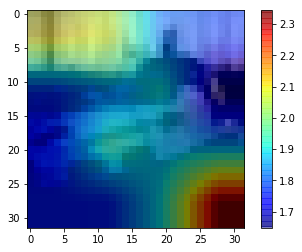

In [76]:
plt.imshow(img)
plt.imshow(np.array(img_sal), alpha=0.5, cmap="jet")
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


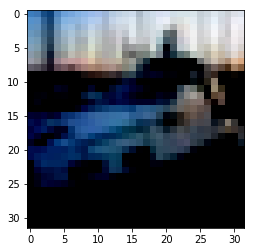

In [77]:
plt.imshow(img)

In [78]:
pp

tensor([[0.8982, 0.0386]], device='cuda:0', grad_fn=<TopkBackward>)

In [79]:
cc

tensor([[8, 1]], device='cuda:0')

In [80]:
sal

array([[2.1339295, 2.0845509, 1.806377 , 1.7703371],
       [1.7619873, 1.8338591, 1.9091606, 1.639981 ],
       [1.7279621, 1.9624796, 1.8611302, 1.8431762],
       [1.7504196, 1.7520065, 1.9041555, 2.3441622]], dtype=float32)

In [81]:
out

tensor([[  97.1153,  100.4200,  -62.0961, -227.8316, -154.8898,   74.6305,
          -25.0145,  149.4408,   31.0311,  -69.0499]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)

In [82]:
c_score

tensor(31.0311, device='cuda:0', grad_fn=<SelectBackward>)

In [83]:
grads

(tensor([[[[-8.4553e-03, -2.6376e-02, -1.2117e-02, -5.2571e-03],
           [-1.9298e-02,  6.0325e-03,  1.1259e-03,  1.3818e-02],
           [ 5.9146e-03, -1.3835e-02, -1.4098e-02, -1.4615e-03],
           [-4.2340e-03,  2.3146e-02,  1.5636e-02,  6.8223e-03]],
 
          [[-2.3439e-02,  3.8609e-03,  1.4817e-02,  1.2491e-02],
           [-1.0532e-03, -9.2252e-04, -4.6461e-04,  2.2978e-02],
           [ 2.0060e-03,  1.1801e-02, -2.8646e-02, -2.4795e-02],
           [-2.3465e-02,  2.1462e-02,  1.6531e-02,  9.7103e-03]],
 
          [[ 1.7858e-02,  2.0798e-02, -9.9797e-04,  2.1265e-02],
           [ 3.9654e-02,  2.4899e-02, -3.0296e-02,  3.4101e-02],
           [ 3.5956e-02,  5.7739e-03,  1.3404e-02,  2.7916e-02],
           [ 3.8599e-02,  3.6018e-02,  4.2184e-02,  3.6232e-02]],
 
          [[ 1.4630e-02,  1.2828e-02, -2.4814e-03,  2.9228e-02],
           [-5.9004e-03, -4.9553e-03,  1.3431e-02,  3.1798e-04],
           [ 1.0032e-02,  1.7406e-02,  2.5357e-02,  3.0635e-02],
           [ 1.3

In [84]:
w

tensor([-0.0020,  0.0008,  0.0227,  0.0113,  0.0009,  0.0008,  0.0233,  0.0263,
         0.0123,  0.0141,  0.0083,  0.0197,  0.0213,  0.0093,  0.0237,  0.0102,
         0.0231,  0.0259,  0.0067,  0.0098,  0.0022,  0.0047, -0.0023,  0.0050,
         0.0059,  0.0130,  0.0074,  0.0219,  0.0116,  0.0070,  0.0083,  0.0040],
       device='cuda:0')